# Step 6: Video generation with Inpainting


This notebook demonstrates how to enhance existing images using inpainting techniques and then generate videos featuring those enhanced images. The workflow combines Amazon Bedrock's image generation capabilities with video generation to create dynamic visual content by first searching for relevant images in Amazon OpenSearch using natural language queries and retrieving image files and their metadata from Amazon S3. It then uses two different inpainting approaches - the Mask Prompt Method which uses text descriptions to identify areas for modification, and the Mask Image Method which uses explicit image masks to define areas for modification.


The notebook applies Amazon Bedrock's Nova-Canvas model to generate creative additions to images, such as adding a party hat to a dog's image in our example. After enhancing the image, it uploads the result to Amazon S3, uses the inpainted image as input for video generation, adds dynamic camera movements based on prompts, and finally generates and displays a short video featuring the enhanced image. This process demonstrates how to seamlessly integrate image enhancement with video creation for compelling visual content.

## Table of Contents

1. [Setup and Dependencies](#Setup-and-Dependencies)
2. [Query OSS](#Query-OSS)
3. [Inpainting with Mask Image](#Inpainting-with-Mask-Image)
4. [Video generation using the inpainted image](#Video-generation-using-the-inpainted-image)

***

## Setup and Dependencies

First, we'll import the necessary libraries and modules. We'll also import functions from our previous notebooks to avoid code duplication.

In [1]:
!pip install -r requirements.txt --quiet

In [2]:
import nbimporter
import base64
import boto3
from botocore.exceptions import ClientError
import os

from _01_oss_ingestion import query_open_search, get_oss_client
from _02_video_gen_text_only import monitor_video_generation, download_and_display_video, start_video_generation
from _03_video_gen_text_image import build_model_input
from _05_inpainting import generate_image, ImageMasking

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[05/13/25 14:00:47] INFO     Found credentials from IAM Role:                                   ]8;id=479375;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=583150;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [3]:
# Install necessary dependencies
!pip install -U boto3 botocore --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 1.38.7 requires botocore==1.37.7, but you have botocore 1.38.14 which is incompatible.
awscli 1.38.7 requires s3transfer<0.12.0,>=0.11.0, but you have s3transfer 0.12.0 which is incompatible.


In [4]:
%store -r REGION
%store -r COLLECTION_ENDPOINT
%store -r INDEX_NAME
%store -r OUTPUT_DIR
%store -r BUCKET

bedrock_runtime_client = boto3.client("bedrock-runtime", REGION)
s3_client = boto3.client('s3')
image_generation_model_id = "amazon.nova-canvas-v1:0"

[05/13/25 14:00:51] INFO     Found credentials from IAM Role:                                   ]8;id=51938;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=160442;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

## Query OSS

This code segment establishes a connection to OpenSearch Service by creating an oss_client using the get_oss_client function with the provided collection endpoint and region parameters. It then sets up an image prompt "the dog looks to the left" and queries the OpenSearch index to find matching images using the query_open_search function, limiting the results to the top match.


After retrieving the search results, the code extracts the S3 key for both the base64-encoded image and the original image by parsing the respective URI paths from the search result. Finally, it obtains the base filename by extracting just the name portion without the file extension from the image's S3 key.

In [5]:
oss_client = get_oss_client(COLLECTION_ENDPOINT, REGION)

[05/13/25 14:00:58] INFO     Found credentials from IAM Role:                                   ]8;id=756335;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=715797;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

In [6]:
image_prompt = "dog"
results = query_open_search(bedrock_runtime=bedrock_runtime_client, oss_client=oss_client, index_name=INDEX_NAME, prompt=image_prompt, top_k=1)

                    INFO     POST                                                                       ]8;id=756405;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/opensearchpy/connection/base.py\base.py]8;;\:]8;id=493632;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/opensearchpy/connection/base.py#258\258]8;;\
                             https://rebg1fbeihnb03iqbs2k.us-east-1.aoss.amazonaws.com:443/vrag-index/_            
                             search                                                                                

In [7]:
image_base64_s3_key = "/".join(results[0]['_source']['image_base64_s3_uri'].split('/')[3:])

In [8]:
image_s3_key = "/".join(results[0]['_source']['image_s3_uri'].split('/')[3:])

In [9]:
base_file_name = image_s3_key.split('/')[-1].split('.')[0]

## Inpainting with Mask Image

This code snippet sets up an image inpainting process that modifies a dog photo using a precisely defined mask image. First, it initializes an ImageMasking object with S3 parameters to handle the masking operations, providing the S3 client, bucket name, file key of the source image, and the base filename for organizational purposes. Then, it calls the generate_image function to perform the actual image generation, referencing both the base64-encoded and standard S3 keys of the original image. 

Key features of Image Masker:

* Interactive sliders to adjust the position and dimensions of a rectangular mask
* A real-time visual preview showing a red rectangle representing the current mask area
* "Save Mask" button that saves both the mask and the original image to a local directory structure (images/inpainting/[base_file_name])
* "Clear Selection" button to reset the mask parameters
* The saved mask uses white (255) for areas outside the selection and black (0) for the selected area
* Both the mask and original image are resized to 1280x720 resolution before saving

In [20]:
# Create the ImageMasking instance with S3 parameters
image_masker = ImageMasking(s3_client, bucket_name=BUCKET, file_key=image_s3_key, base_file_name=base_file_name)

Generating image(s)...
Image saved to images/inpainting/dog/mask_image_1.jpg
Image saved to images/inpainting/dog/mask_image_2.jpg
Image saved to images/inpainting/dog/mask_image_3.jpg
Image saved to images/inpainting/dog/mask_image_4.jpg


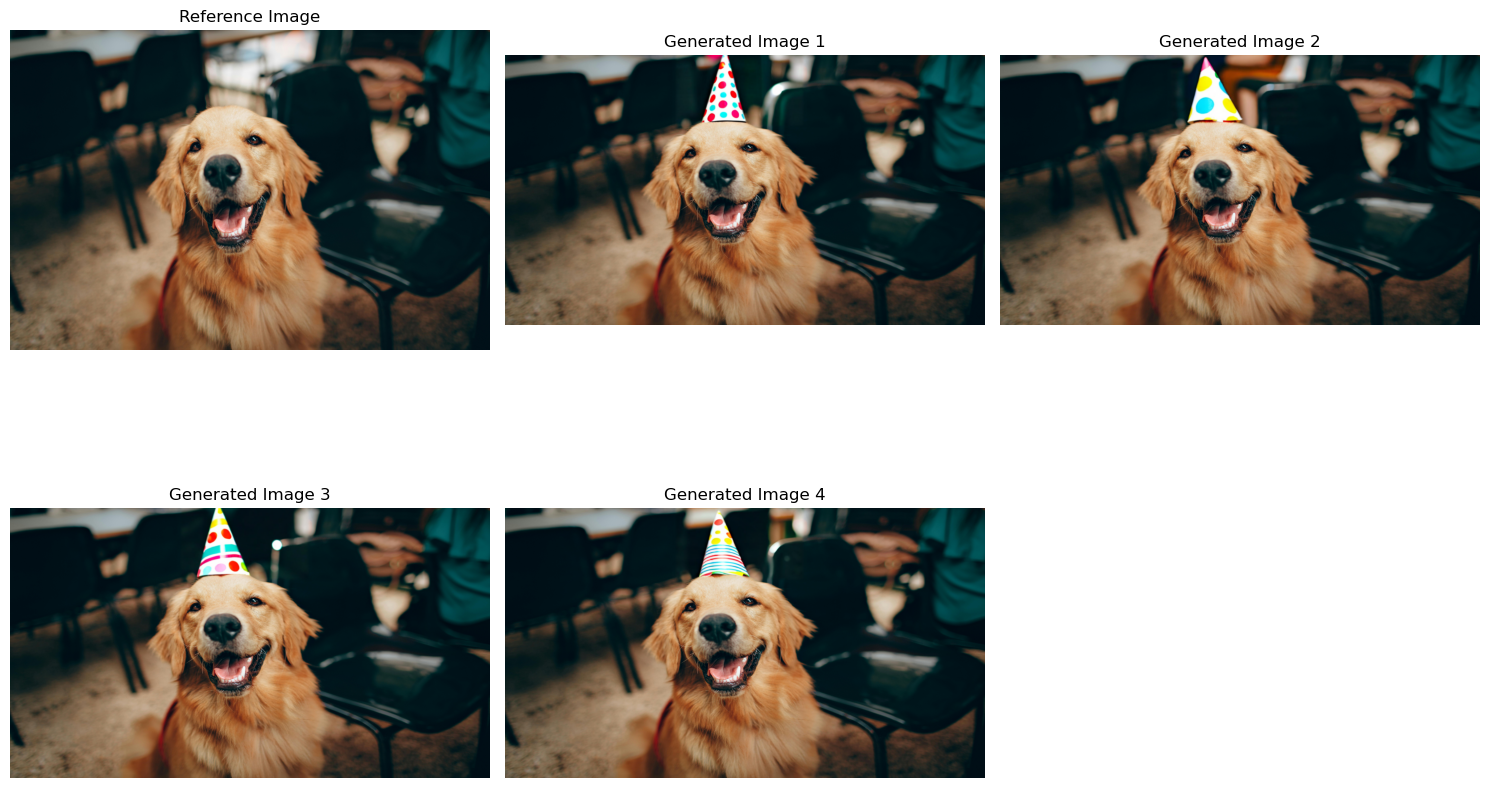

[<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1280x720>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1280x720>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1280x720>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1280x720>]

In [12]:
# Using mask image
generate_image(
    image_base64_s3_key=image_base64_s3_key,
    image_s3_key=image_s3_key,
    bucket=BUCKET,
    s3_client=s3_client,
    bedrock_runtime_client=bedrock_runtime_client,
    image_generation_model_id=image_generation_model_id,
    output_image_path=f"images/inpainting/{base_file_name}/mask_image.jpg",
    text="a dog with a colorful pointed party birthday hat with stripes and polka dots",
    negative_text="blur, distortion",
    seed=42,
    mask_image_path=f"images/inpainting/{base_file_name}/mask.png",
    num_images=4,
    save_all=True
)

## Video generation using the inpainted image


This code snippet demonstrates a workflow for generating a dynamic video from an inpainted image. The process begins by defining an action prompt describing the desired camera movement as a "dynamic handheld shot." The code then includes a function called upload_file_to_s3 that converts a local image file to base64 encoding before uploading it to an Amazon S3 bucket, handling any potential errors during the process. Two helper functions follow: read_s3_text retrieves text content from S3, and vrag (video generation) builds a model input combining the action prompt with the base64-encoded image, specifying video parameters like duration (6 seconds), frame rate (24 fps), and resolution (1280x720). The code then initiates video generation through Amazon Bedrock Runtime, monitors the generation process until completion, and finally downloads and displays the resulting video

In [13]:
action_prompt = "A tight ground-level shot capturing dog"

In [14]:
def upload_file_to_s3(local_file_path, bucket_name, key_file):
    """
    Upload a local file to an S3 bucket after converting it to base64
    
    Parameters:
    local_file_path (str): The path to the local file
    bucket_name (str): The name of the S3 bucket
    key_file (str): The key (path/filename) under which the file will be stored in S3
    
    Returns:
    bool: True if file was uploaded, False otherwise
    """
    try:
        # Read the image file and convert to base64
        with open(local_file_path, 'rb') as image_file:
            encoded_string = base64.b64encode(image_file.read()).decode('utf-8')
        
        # Upload the base64 string directly to S3
        s3_client.put_object(
            Body=encoded_string,
            Bucket=bucket_name,
            Key=key_file
        )
        
        print(f"Successfully uploaded base64-encoded {local_file_path} to {bucket_name}/{key_file}")
        return True
        
    except ClientError as e:
        print(f"Error uploading file to S3: {e}")
        return False
    except Exception as e:
        print(f"Error processing file: {e}")
        return False

In [15]:
inpainted_image_local_path = "images/inpainting/dog/mask_image_1.jpg"
inpainted_image_s3_key_file = "inpainted_images/dog.jpg"

upload_file_to_s3(inpainted_image_local_path, BUCKET , inpainted_image_s3_key_file)

Successfully uploaded base64-encoded images/inpainting/dog/mask_image_1.jpg to vrag-blogpost-s3bucket-rr09alr6dgj4/inpainted_images/dog.jpg


True

In [16]:
def read_s3_text(bucket_name, file_key):
    try:
        response = s3_client.get_object(Bucket=bucket_name, Key=file_key)
        text_content = response['Body'].read().decode('utf-8')
        return text_content
    except Exception as e:
        print(f"Error reading file from S3: {e}")
        return None

In [17]:
def vrag(image_prompt, camera_prompt):
    model_input = build_model_input(action_prompt, image_base64=read_s3_text(BUCKET,inpainted_image_s3_key_file), duration=6, fps=24, resolution="1280x720", seed=0)
    invocation = start_video_generation(bedrock_runtime_client, BUCKET, model_input)
    return monitor_video_generation(bedrock_runtime_client, invocation["invocationArn"])

In [18]:
video_uri = vrag(image_prompt, image_prompt+action_prompt)

Video generation job started successfully.
Job arn:aws:bedrock:us-east-1:222634405177:async-invoke/wdv0pp5f68iq is in progress. Started at: 2025-05-13 14:03:58+00:00
Job arn:aws:bedrock:us-east-1:222634405177:async-invoke/wdv0pp5f68iq is in progress. Started at: 2025-05-13 14:03:58+00:00
Job arn:aws:bedrock:us-east-1:222634405177:async-invoke/wdv0pp5f68iq is in progress. Started at: 2025-05-13 14:03:58+00:00
Video generation completed. Video available at: s3://vrag-blogpost-s3bucket-rr09alr6dgj4/wdv0pp5f68iq/output.mp4


In [19]:
download_and_display_video(s3_client, BUCKET, video_uri, OUTPUT_DIR)

output_video/wdv0pp5f68iq.mp4
Video downloaded to output_video/wdv0pp5f68iq.mp4.
